# Hamming weight phasing using addition circuits

In this notebook we describe how to use the Adder primitive to compute the Hamming weight of a bitstring into a register. To understand how this works we first describe the adder primitive MAJ and UMA followed by how to use the adder primitives to compute Hamming weight. 

## Reversible adders, MAJ, and UMA

A full adder takes two input bits ($a$ and $b$) and an input carry bit ($c$) and outputs the sum of ($a$ + $b$ + $c$) as a sum bit $s$ and a carry bit $c_{+1}$.  This is the same type of addition that happens in base 10 but instead of carrying on 10 we carry on 2. In a reversible setting we use the input carry bit to store $c \oplus a$, the $b$ bit stores $a \oplus b$, and the $a$ bit stores the ouput carry bit $c_{+1}$. This is the ordering used in [A new quantum ripple-carry addition circuit](https://arxiv.org/abs/quant-ph/0410184) in the definition of the $\mathrm{MAJ}(a, b, c)$ gate.  The $\mathrm{UMA}$ gate uncomputes the XOR operations and writes the $a$ bit back to the $a$ register, overwrites the $b$ register with the sum of $a \oplus b \oplus c$, and restores the original carry bit $c$.  Using these two primitives one can construct the full ripple carry adder for two $n$-bit numbers by $n$ calls to $\mathrm{MAJ}$ and $n$ calls to $\mathrm{UMA}$. One also uses an additional ancilla bit to store the final carry bit (copied via a CNOT) before uncomputing with $n$ $\mathrm{UMA}$. Here are links to the [$\mathrm{MAJ}$](https://algassert.com/quirk#circuit={%22cols%22:[[1,%22X%22,%22%E2%80%A2%22],[%22X%22,1,%22%E2%80%A2%22],[%22%E2%80%A2%22,%22%E2%80%A2%22,%22X%22]],%22init%22:[0,0]}) and [$\mathrm{UMA}$](https://algassert.com/quirk#circuit={%22cols%22:[[1,%22X%22],[%22%E2%80%A2%22,%22X%22],[%22%E2%80%A2%22,%22%E2%80%A2%22,%22X%22],[1,%22X%22],[%22X%22,1,%22%E2%80%A2%22],[1,%22X%22,%22%E2%80%A2%22]]}) circuit as a quirk circuit. Using a logical-AND along with an additional ancilla Craig reduced the Toffoli gate count by 1 for an equivalent $\mathrm{MAJ}$ and $\mathrm{UMA}$ [(quirk circuit)](https://algassert.com/quirk#circuit={%22cols%22:[[%22%E2%80%A2%22,%22X%22,%22X%22],[1,%22%E2%80%A2%22,%22%E2%80%A2%22,%22X%22],[%22%E2%80%A2%22,1,1,%22X%22],[%22%E2%80%A2%22,1,1,%22X%22],[1,%22%E2%80%A2%22,%22%E2%80%A2%22,%22X%22],[%22%E2%80%A2%22,1,%22X%22],[1,%22X%22,%22%E2%80%A2%22]]}) and the T-gates by half using the fact that the when a pair of Toffoli are used to compute and uncompute a state one can reduce the number of T gates.

Craig's adder circuit operates slightly differently to the $\mathrm{MAJ}$ and $\mathrm{UMA}$ primtives. The first part of the circuit primtive takes as input $a,b,c$ as before and computes the carry bit into the ancilla of the logical-AND. The input bits $a$ and $b$ now store their respective $a \oplus c$ and $b \oplus c$. The input carry bit does not change. You can confirm the ouput using [this](https://algassert.com/quirk#circuit={%22cols%22:[[%22%E2%80%A2%22,%22X%22,%22X%22],[1,%22%E2%80%A2%22,%22%E2%80%A2%22,%22X%22],[%22%E2%80%A2%22,1,1,%22X%22]],%22init%22:[0]}) quirk circuit.  The second half of the circuit uncomputes the carry bit and computes the sum and uncomputes the $a \oplus c$ and $b \oplus c$. The $b$ register is overwritten with the sum.

For our Hamming weight circuit we will need a slight modification to the adder where using four bits we compute the sum and carry of $a + b + c$.  This circuit requires a single Toffoli from the logical-AND and zero Toffoli to uncompute. The circuit for the out-of-place adder can be found [here](https://algassert.com/quirk#circuit={%22cols%22:[[%22%E2%80%A2%22,%22X%22,%22X%22],[1,%22%E2%80%A2%22,%22%E2%80%A2%22,%22X%22],[%22%E2%80%A2%22,%22X%22,1,%22X%22],[1,%22%E2%80%A2%22,%22X%22]]}) which corresponds to figure 4b of [Halving the cost of quantum addition](https://quantum-journal.org/papers/q-2018-06-18-74/).  Reading this circuit from top to bottom has inputs $a,b,c,0$ and ouputs $a,b,(a+b+c),(a+b+c)_{1}$ where the $1$ subscript on the last qubit denotes it is the carry bit from the sum.

## Computing Hamming weight by out-of-place adders

Our goal is to compute the Hamming weight into a register and use the binary-to-unary representation of integers to reduce the number of rotations needed to apply $R_{z}(\theta)$ to $n$ qubits.  As is stated in [Improved Fault-Tolerant Quantum Simulation of Condensed-Phase Correlated Electrons via Trotterization](https://quantum-journal.org/papers/q-2020-07-16-296/) page 18, ``We begin with $n$ qubits to which a rotation Rz(θ) must be applied. We call these initial qubits 'weight-1' qubits: our goal is to combine them such that we are left with one qubit which captures each digit of the Hamming weight, i.e., one qubit each of weight $1, 2, 4, 8, . . ., 2^{\lfloor \log2(n) \rfloor}$''--or in other words, $|k\rangle \rightarrow |w(k)\rangle$ where $w(k)$ is the binary representation of the Hamming weight of $k$.

In order to understand how this circuit works we first point out that the out-of-place adder by Gidney converts three bits into a binary representation of the sum of those three bits. Recall the adder works by converting $a,b,c,0$ and ouputs $a,b,(a+b+c),(a+b+c)_{1}$. The last two bits $(a+b+c), (a+b+c)_{1}$ are the binary representation of the Hamming weight for the input of the three bits $w(|a,b,c\rangle) = 2^{0}(a+b+c)_{0} + 2^{1}(a+b+c)_{1}$.  The next point to understand is that in this construction for computing the Hamming weight we view each digit (qubit) as binary $2^{0}b_{i}$. Thus $|k\rangle$ can be thought of as $2^{0}k_{0} + 2^{0}k_{1} + ... + 2^{0}k_{n-1}$. Let's consider a concrete 7-bit state $2^{0}b_{0} +  2^{0}b_{1} + 2^{0}b_{2} + 2^{0}b_{3} + 2^{0}b_{4} + 2^{0}b_{5} + 2^{0}b_{6}$. We now can apply the adder to the first three bits producing a binary representation

$$
2^{1}(b_{0}+b_{1} + b_{2})_{1} + 2^{0}(b_{0}+b_{1} + b_{2})_{0} + 2^{0}b_{3} + 2^{0}b_{4} + 2^{0}b_{5} + 2^{0}b_{6}
$$
we then sum the next three bits corresponding to $2^{0}$ and sum those
$$
2^{1}(b_{0}+b_{1} + b_{2})_{1} + 2^{1}((b_{0}+b_{1} + b_{2})_{0} + b_{3} + b_{4})_{1} + 2^{0}((b_{0}+b_{1} + b_{2})_{0} + b_{3} + b_{4})_{0} + 2^{0}b_{5} + 2^{0}b_{6}
$$
we then sum the final three bits corresponding to $2^{0}$
$$
2^{1}(b_{0}+b_{1} + b_{2})_{1} + 2^{1}((b_{0}+b_{1} + b_{2})_{0} + b_{3} + b_{4})_{1} + 2^{1}(((b_{0}+b_{1} + b_{2})_{0} + b_{3} + b_{4})_{0} + b_{5} + b_{6})_{1} + 2^{0}(((b_{0}+b_{1} + b_{2})_{0} + b_{3} + b_{4})_{0} + b_{5} + b_{6})_{0}
$$
the final expression on the right is the $2^{0}$ binary component of the Hamming weight.  This worked because all the other qubits are storing the carry bits which would correspond to $2^{1}$ binary components.  We now need to add these together. For ease of notation we assign $t_{1} = (b_{0}+b_{1} + b_{2})_{1}$, $t_{2} = ((b_{0}+b_{1} + b_{2})_{0} + b_{3} + b_{4})_{1}$, and $t_{3} = (((b_{0}+b_{1} + b_{2})_{0} + b_{3} + b_{4})_{0} + b_{5} + b_{6})_{1}$. We now have
$$
2^{1}t_{1} + 2^{1}t_{2} + 2^{1}t_{3} + 2^{0}(((b_{0}+b_{1} + b_{2})_{0} + b_{3} + b_{4})_{0} + b_{5} + b_{6})_{0}
$$
which we add together to produce
$$
2^{2}(t_{1} + t_{2} + t_{3})_{1} + 2^{1}(t_{1} + t_{2} + t_{3})_{0} + 2^{0}(((b_{0}+b_{1} + b_{2})_{0} + b_{3} + b_{4})_{0} + b_{5} + b_{6})_{0}
$$
which is the Hamming weight of our 7-bit string.  

In [1]:
from qualtran.bloqs.arithmetic import OutOfPlaceAdderBuildingBlock
from qualtran.drawing import show_bloq
from qualtran.drawing import get_musical_score_data, draw_musical_score

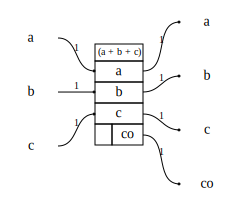

(-1.35, 6.35, -3.1550000000000002, 0.255)

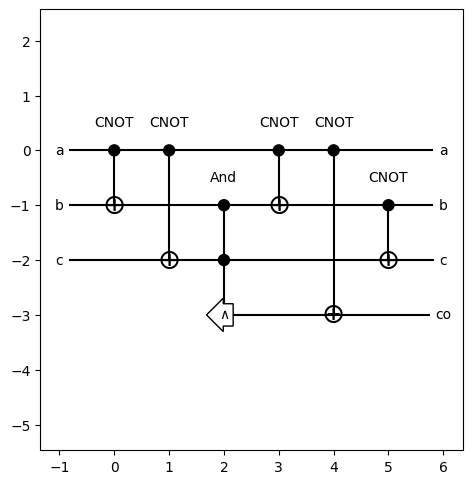

In [2]:
show_bloq(OutOfPlaceAdderBuildingBlock())
msd = get_musical_score_data(OutOfPlaceAdderBuildingBlock().decompose_bloq())
fig, ax = draw_musical_score(msd)
ax.axis('equal')

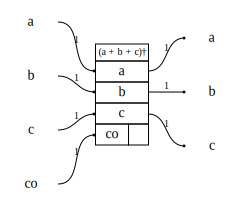

(-1.35, 6.35, -3.1550000000000002, 0.255)

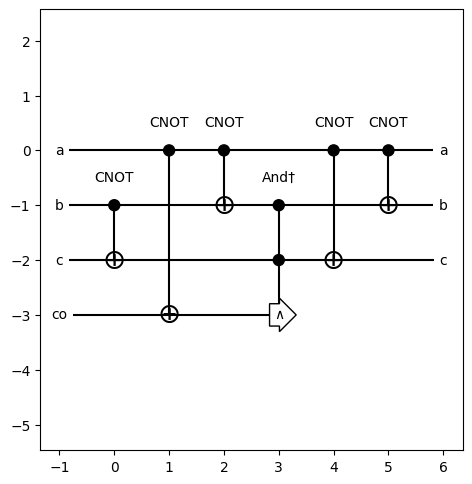

In [3]:
bloq_inv = OutOfPlaceAdderBuildingBlock(adjoint=True)
show_bloq(bloq_inv)
msd = get_musical_score_data(bloq_inv.decompose_bloq())
fig, ax = draw_musical_score(msd)
ax.axis('equal')

# space and time complexity